In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.PropertyMol import PropertyMol
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
import pickle
import sys
from pathlib import Path
import matplotlib.pyplot as plt

In [46]:
sys.path.append('/home/paula/Masterarbeit/KinaseFocusedFragmentLibrary/kinase_focused_fragment_library/analysis/ligand_analysis')
from construct_ligand import construct_ligand, read_fragment_library
from analyze_results import is_drug_like
sys.path.append('/home/paula/Masterarbeit/KinaseFocusedFragmentLibrary/kinase_focused_fragment_library/recombination')

In [3]:
def pickle_loader(pickle_file):

    try:
        while True:
            yield pickle.load(pickle_file)
    except EOFError:
        pass

### Load fragments and original KLIFS ligands

In [4]:
# load fragments (reduced library)
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']
data = read_fragment_library(Path('/home/paula/Masterarbeit/FragmentLibrary'), subpockets)

Number of fragments in AP : 230
Number of fragments in FP : 254
Number of fragments in SE : 160
Number of fragments in GA : 100
Number of fragments in B1 : 23
Number of fragments in B2 : 34


In [29]:
kinases_pdbs = set()
for sp in data:
    for frag in data[sp]:
        kinases_pdbs.add((frag.GetProp('kinase'), frag.GetProp('_Name')))

In [43]:
# load KLIFS ligands where those fragments originated from
klifs_ligands = []
for kinase, pdb in kinases_pdbs:
    f = '/home/paula/Masterarbeit/data/KLIFS_download/HUMAN/'+kinase+'/'+pdb+'/ligand.mol2'
    ligand = Chem.MolFromMol2File(f)
    ligand.SetProp('complex_pdb', pdb)
    klifs_ligands.append(ligand)

In [48]:
# calculate lipinski statistics of original ligands
lipinski_klifs, wt_klifs, logp_klifs, hbd_klifs, hba_klifs = 0, 0, 0, 0, 0
for ligand in klifs_ligands:
    lipinski, wt, logp, hbd, hba = is_drug_like(ligand)
    lipinski_klifs += lipinski
    wt_klifs += wt
    logp_klifs += logp
    hbd_klifs += hbd
    hba_klifs += hba

In [51]:
count_klifs = len(klifs_ligands)
count_klifs

694

### Load recombinations and statistics:

In [33]:
combinatorial_library_folder = Path('/home/paula/Masterarbeit/CombinatorialLibrary_manuscript/')
file_name = combinatorial_library_folder / 'combinatorial_library.pickle'

In [34]:
# initializations

count_ligands = 0
lipinski_ligands, filtered_ligands = 0, 0
wt_ligands = 0
logp_ligands = 0
hbd_ligands = 0
hba_ligands = 0
originals = 0
original_subs = 0
chembl_match = 0
scaffold = 0
novel = 0

subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']

n_per_sp, n_filtered_per_sp = {}, {}
for subpocket in subpockets:
    n_per_sp[subpocket] = 0
    n_filtered_per_sp[subpocket] = 0

n_sp, n_filtered_sp = {}, {}
for i in range(len(subpockets)):
    n_sp[i+1] = 0
    n_filtered_sp[i+1] = 0
    
n_atoms = {}
n_atoms_filtered = {}

In [37]:
# combining the results

with open(file_name, 'rb') as pickle_file:

    for result in pickle_loader(pickle_file):
        
        if result is None:
            continue

        count_ligands += 1

        # number of subpockets
        n_sp[result.n_subpockets] += 1
        # occupied subpockets
        for frag_id in result.meta.frag_ids:
            n_per_sp[frag_id[:2]] += 1

        # lipinski rule
        lipinski_ligands += result.lipinski
        wt_ligands += result.mwt
        logp_ligands += result.logp
        hbd_ligands += result.hbd
        hba_ligands += result.hba

        n = result.n_atoms
        # if Lipinski rule fulfilled
        if result.lipinski == 1:
            n_filtered_sp[len(result.meta.frag_ids)] += 1
            n_atoms_filtered[n] = n_atoms_filtered[n] + 1 if n in n_atoms_filtered else 1
            for frag_id in result.meta.frag_ids:
                n_filtered_per_sp[frag_id[:2]] += 1
            filtered_ligands += 1

        # original ligands
        originals += result.original
        original_subs += result.original_sub

        # chembl
        chembl_match += result.chembl_match

        # novel ligand
        if result.chembl_match == 0 and result.original == 0 and result.original_sub == 0:
            novel += 1

        # number of atoms
        n_atoms[n] = n_atoms[n] + 1 if n in n_atoms else 1
        

In [38]:
print(count_ligands)

15881010


In [39]:
print('Number of resulting ligands:', count_ligands)
print('Exact match in original ligands:', originals)
print('Substructures of original ligands:', original_subs)
print('Exact match in ChEMBL:', chembl_match)
print('Novel ligand:', novel)
print('Lipinski rule of 5 fulfilled:', lipinski_ligands, lipinski_ligands/count_ligands)
print('Molecular weight <= 500:', wt_ligands, wt_ligands/count_ligands)
print('LogP <= 5:', logp_ligands, logp_ligands/count_ligands)
print('HB donors <= 5:', hbd_ligands, hbd_ligands/count_ligands)
print('HB acceptors <= 10:', hba_ligands, hba_ligands/count_ligands)

Number of resulting ligands: 15881010
Exact match in original ligands: 43
Substructures of original ligands: 167
Exact match in ChEMBL: 168
Novel ligand: 15880679
Lipinski rule of 5 fulfilled: 6277032 0.39525395425102056
Molecular weight <= 500: 3908277 0.24609750891158685
LogP <= 5: 10094098 0.6356080627113767
HB donors <= 5: 15162246 0.9547406619604168
HB acceptors <= 10: 8877459 0.5589983886415285


### Plot statistics

['24.6', '63.6', '95.5', '55.9', '39.5']


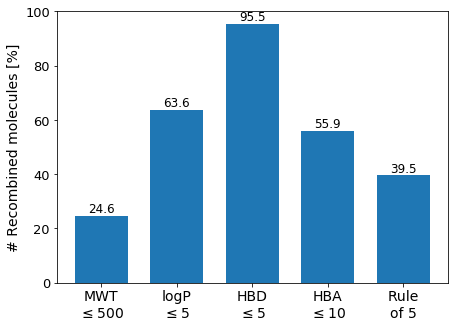

In [40]:
# plot Lipinski rule
rules = [wt_ligands/count_ligands*100, logp_ligands/count_ligands*100, hbd_ligands/count_ligands*100,
         hba_ligands/count_ligands*100, lipinski_ligands/count_ligands*100]
plt.figure(figsize=(7,5))
ax = plt.bar(range(5), rules, width=0.7)
plt.ylabel('# Recombined molecules [%]', fontsize=14)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$'
                      , 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=14)
plt.yticks(fontsize=13)
rects = ax.patches
# calculate percentages
labels = [str(round(n, 1)) for n in rules]
print(labels)
for rect, label in zip(rects, labels):
   height = rect.get_height()
   if height != 100 and height != 0:
       plt.text(rect.get_x() + rect.get_width() / 2, height + 0.2, label, ha='center', va='bottom', fontsize=12)
# plt.savefig(combinatorial_library_folder / 'lipinski.png')


['82.4', '90.2', '98.4', '98.6', '93.7']
['24.6', '63.6', '95.5', '55.9', '39.5']


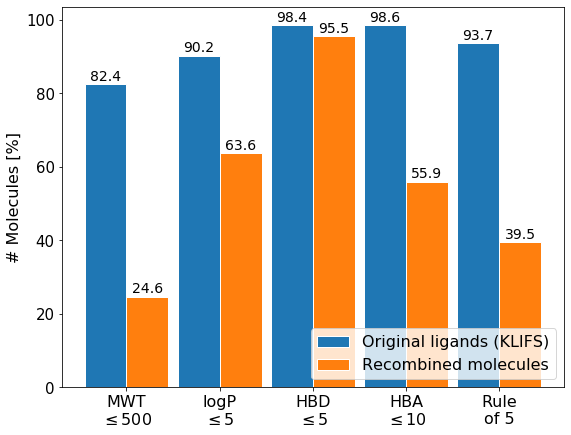

In [69]:
# lipinski rule plot for original KLIFS ligands vs recombined molecules
rules_klifs = [wt_klifs/count_klifs*100, logp_klifs/count_klifs*100, hbd_klifs/count_klifs*100, 
               hba_klifs/count_klifs*100, lipinski_klifs/count_klifs*100]
rules = [wt_ligands/count_ligands*100, logp_ligands/count_ligands*100, hbd_ligands/count_ligands*100,
         hba_ligands/count_ligands*100, lipinski_ligands/count_ligands*100]

plt.figure(figsize=(9,7))
barWidth, space = 0.45, 0.2

ax1 = plt.bar(range(5), rules_klifs, label='Original ligands (KLIFS)', width=barWidth, edgecolor='white')
x_values = [x+barWidth for x in range(5)]
ax2 = plt.bar(x_values, rules, label='Recombined molecules', width=barWidth, edgecolor='white')

plt.ylabel('# Molecules [%]', fontsize=16)
plt.xticks([r + barWidth/2 for r in range(5)], ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$'
                      , 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=16)
plt.yticks(fontsize=15)

rects1, rects2 = ax1.patches, ax2.patches
# calculate percentages
labels1 = [str(round(n, 1)) for n in rules_klifs]
labels2 = [str(round(n, 1)) for n in rules]

for rect1, rect2, label1, label2 in zip(rects1, rects2, labels1, labels2):
    height = rect1.get_height()
    if height != 100 and height != 0:
        plt.text(rect1.get_x() + rect1.get_width() / 2, height + 0.2, label1, fontsize=14, ha='center', va='bottom')
    height = rect2.get_height()
    if height != 100 and height != 0:
        plt.text(rect2.get_x() + rect2.get_width() / 2, height + 0.2, label2, fontsize=14, ha='center', va='bottom')

plt.legend(loc='lower right', fontsize=16)

print(labels1)
print(labels2)   
        
plt.savefig('/home/paula/Masterarbeit/manuscript/Figures/ra_lipinski.png', dpi=300)

plt.show()

['0.0', '0.1', '7.2', '92.7', '0.0', '0.0']
['0.0', '0.2', '15.0', '84.8', '0.0', '0.0']


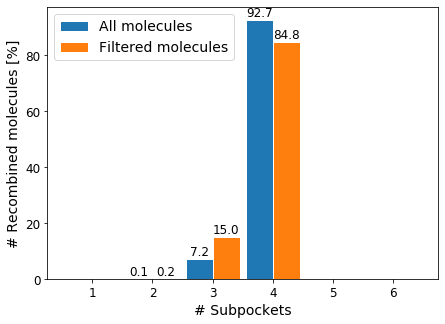

In [40]:
# plot number of subpockets per ligand
plt.figure(figsize=(7,5))
barWidth, space = 0.45, 0.2

x_values = list(map(int, n_sp.keys()))
ax1 = plt.bar(x_values, [n/count_ligands*100 for n in n_sp.values()], label='All molecules', width=barWidth, edgecolor='white')
x_values = [x+barWidth for x in list(map(int, n_filtered_sp.keys()))]
ax2 = plt.bar(x_values, [n/filtered_ligands*100 for n in n_filtered_sp.values()], label='Filtered molecules',
              width=barWidth, edgecolor='white')

plt.ylabel('# Recombined molecules [%]', fontsize=14)
plt.xlabel('# Subpockets', fontsize=14)

rects1, rects2 = ax1.patches, ax2.patches
# calculate percentages
labels1 = [str(round(n/count_ligands*100, 1)) for n in n_sp.values()]
labels2 = [str(round(n/filtered_ligands*100, 1)) for n in n_filtered_sp.values()]
for rect1, rect2, label1, label2 in zip(rects1, rects2, labels1, labels2):
    height = rect1.get_height()
    if height != 100 and height != 0:
        plt.text(rect1.get_x() + rect1.get_width() / 2, height + 0.2, label1, fontsize=12, ha='center', va='bottom')
    height = rect2.get_height()
    if height != 100 and height != 0:
        plt.text(rect2.get_x() + rect2.get_width() / 2, height + 0.2, label2, fontsize=12, ha='center', va='bottom')

plt.xticks([r + barWidth/2 for r in range(1, 7)], range(1, 7), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_subpockets.png')

print(labels1)
print(labels2)

['100.0', '93.9', '94.1', '94.7', '4.8', '5.2']
['100.0', '91.7', '94.3', '89.1', '4.4', '5.2']


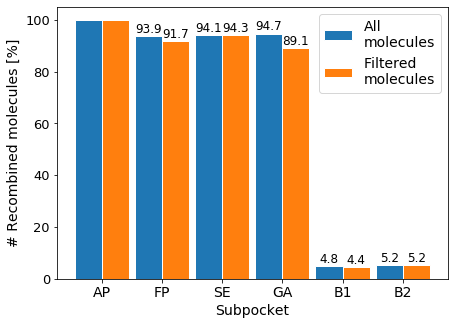

In [42]:
# plot number of fragments/ligands occupying each subpocket
plt.figure(figsize=(7,5))
barWidth, space = 0.45, 0.2
ax1 = plt.bar(range(6), [n/count_ligands*100 for n in n_per_sp.values()], label='All\nmolecules', width=barWidth, edgecolor='white')
x_values = [x+barWidth for x in range(6)]
ax2 = plt.bar(x_values, [n/filtered_ligands*100 for n in n_filtered_per_sp.values()], label='Filtered\nmolecules', width=barWidth, edgecolor='white')

plt.ylabel('# Recombined molecules [%]', fontsize=14)
plt.xlabel('Subpocket', fontsize=14)
rects1, rects2 = ax1.patches, ax2.patches
# calculate percentages
labels1 = [str(round(n/count_ligands*100, 1)) for n in n_per_sp.values()]
labels2 = [str(round(n/filtered_ligands*100, 1)) for n in n_filtered_per_sp.values()]
for rect1, rect2, label1, label2 in zip(rects1, rects2, labels1, labels2):
    height = rect1.get_height()
    if height != 100 and height != 0:
        plt.text(rect1.get_x() + rect1.get_width() / 2, height + 0.2, label1, fontsize=12, ha='center', va='bottom')
    height = rect2.get_height()
    if height != 100 and height != 0:
        plt.text(rect2.get_x() + rect2.get_width() / 2, height + 0.2, label2, fontsize=12, ha='center', va='bottom')

plt.xticks([x + barWidth / 2 for x in range(6)], n_per_sp.keys(), fontsize=14)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_frags.png')

print(labels1)
print(labels2)

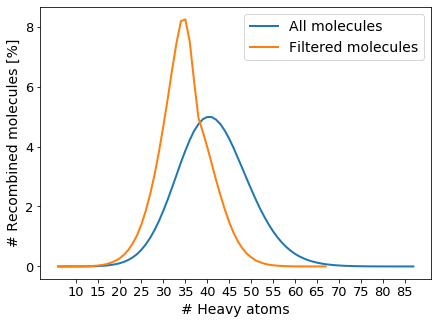

In [44]:
# plot number of atoms per ligand
plt.figure(figsize=(7,5))
x = sorted(n_atoms)
y = [n_atoms[key] for key in sorted(n_atoms)]
plt.plot(x, [n/count_ligands*100 for n in y], label='All molecules', linewidth=2)
#plt.bar(n_atoms.keys(), [n/count_ligands*100 for n in n_atoms.values()])
x = sorted(n_atoms_filtered)
y = [n_atoms_filtered[key] for key in sorted(n_atoms_filtered)]
plt.plot(x, [n/filtered_ligands*100 for n in y], label='Filtered molecules', linewidth=2)
plt.xticks(range(10, max(n_atoms)+1, 5), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('# Heavy atoms', fontsize=14)
plt.ylabel('# Recombined molecules [%]', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
# plt.savefig(combinatorial_library_folder / 'n_atoms.png')